# Barghi et al. (2019) Data Processing and Analysis

## Setup

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import re
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

In [3]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

# Data and Annotation Loading

### Load in SyncFile

In [5]:
CACHED_SYNC = '../data/barghi_et_al_2019/barghi_et_al_2019.hdf5'
SYNC_FILE = '../data/barghi_et_al_2019/Dsim_F0-F60_Q20_polymorphic_CMH_FET_blockID.sync.gz'

if not os.path.exists(CACHED_SYNC):
    sf = vf.SyncFile(SYNC_FILE)
    sf.dump_hdf5(CACHED_SYNC)
else:
    sf = vf.SyncFile.load_hdf5(CACHED_SYNC)

total time to load HDF5 file: 0.12601267099380492 mins.


In [6]:
sf_gi = sf.build_gintervals()
sf_gi.seqlens = dict()
with open('../data/dsimulans/dsim-M252-seqlens.txt') as f:
    for line in f:
        seqid, length = line.strip().split('\t')
        sf_gi.seqlens[seqid] = int(length)

In [7]:
keep_seqids = ['2L', '2R', '3L', '3R', 'X']
keep_autos = ['2L', '2R', '3L', '3R']

### Study Design

Next, we parse the sample names  the `README.docx` file (https://datadryad.org/resource/doi:10.5061/dryad.rr137kn/1).

From the readme, the sample name formats are,

```
for the base populations:      species_population_selectionRegime_replicate: e.g. Dsim_Fl_Base_4 
for the evolved populations:   species_population_selectionRegime_generation_replicate: e.g. Dsim_Fl_Hot_F13_1
```

which we parse using regular expressions:

In [8]:
CACHED_DESIGN = '../data/barghi_et_al_2019/barghi_et_al_2019_design.feather'

if not os.path.exists(CACHED_DESIGN):
    RAW_DESIGN_FILE = '../data/barghi_et_al_2019/barghi_et_al_2019_design.txt'
    sample_names = pd.read_csv(RAW_DESIGN_FILE, header=None, names=('col', ))['col'].tolist()
    sample_re = re.compile(r"(?P<species>Dsim)_(?P<pop>Fl)_(?P<selection>Base|Hot)_(F(?P<gen>\d+)_)?(?P<rep>\d+)")
    sample_info = [{'name':d, **re.match(sample_re, d).groupdict()} for d in sample_names]
    design = pd.DataFrame.from_dict(sample_info)
    
    # Barghi et al use base population to refer to generation zero — we set that explicitly here:
    design.loc[design.gen.isnull(), 'gen'] = 0
    design['gen'] = design['gen'].astype('int')
    
    design.to_feather(CACHED_DESIGN)
else:
    design = pd.read_feather(CACHED_DESIGN)

Our `TemporalFreqs()` and `TiledTemporalFreqs()` objects take a list of tuples `(timepoint, replicate)`, which we create via the design DataFrame:

In [9]:
samples = [(int(t), int(r)) for t, r in zip(design['rep'].values, design['gen'].values)]

### Import Annotation

We use the M252 reference genome annotation described by Palmieriet al. (2015). 
These sequence lengths are used for the creation of the tiles.

In [10]:
gtf_file = '../data/dsimulans/dsim-M252-popgen-ann-r1.1.sorted.gtf'
keep_seqids = set('2L 2R 3L 3R 4 X'.split())
dsim = GenomicIntervals.from_gff(gtf_file, filter_type='exon', filter_seqids=keep_seqids, delims=(' ', '; '))

In [11]:
dsim

GenomicIntervals — 6 unique seqids, 169132 features
   GenomicInterval attributes phase   score seqid          source strand  type
0  2L:[3589, 4976)       None     .  1000.0    2L       Cufflinks      -  exon
1  2L:[4846, 4976)       None     1     NaN    2L  protein2genome      -  exon
2  2L:[4846, 4976)       None     1     NaN    2L  protein2genome      -  exon
3  2L:[4846, 4976)       None     1     NaN    2L  protein2genome      -  exon
4  2L:[4941, 4976)       None     2     NaN    2L  protein2genome      -  exon
[ 169127 more GenomicIntervals ]

In [12]:
dsim.infer_seqlens()

## Covariance Analysis

### Creating Tiles

In [13]:
tile_width = 1e5
tiles = GenomicIntervals.from_tiles(dsim.seqlens, width=tile_width)
# add in exonic basepairs:
#tiles = tiles.overlap_coverage(dsim, colname='exonic_bp')

### Calculating Covariances by Tile

In [16]:
d = TiledTemporalFreqs(tiles, freqs=sf.freqs.T, depths=sf.N.T, diploids=1000, gintervals=sf_gi, samples=samples)

In [17]:
del sf

Calculate the temporal-replicate covariances matrices for all tiles. Each covariance matrix has R x T = 60 rows and columns. 

In [18]:
tile_covs = d.calc_covs_by_tile(progress_bar=True)

We reshape these 60 x 60 matrices, extracting the temporal replicates. This gives the ntiles x T x T x R array of temporal covaraince matrices, for each of the R replicates. This numpy array is used to create figures. 

In [24]:
tile_temp_covs = stack_temporal_covs_by_group(tile_covs, d.R, d.T)
with open('../data/barghi_et_al_2019/tile_temporal_covs.npy', 'wb') as f:
    np.save(f, tile_temp_covs)

### Bias Correction Diagnostics Plots

/home/vinceb/projects/cvtk/cvtk/cvtk.py:178: RuntimeWarning: Mean of empty slice.
  het = het.mean()
/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


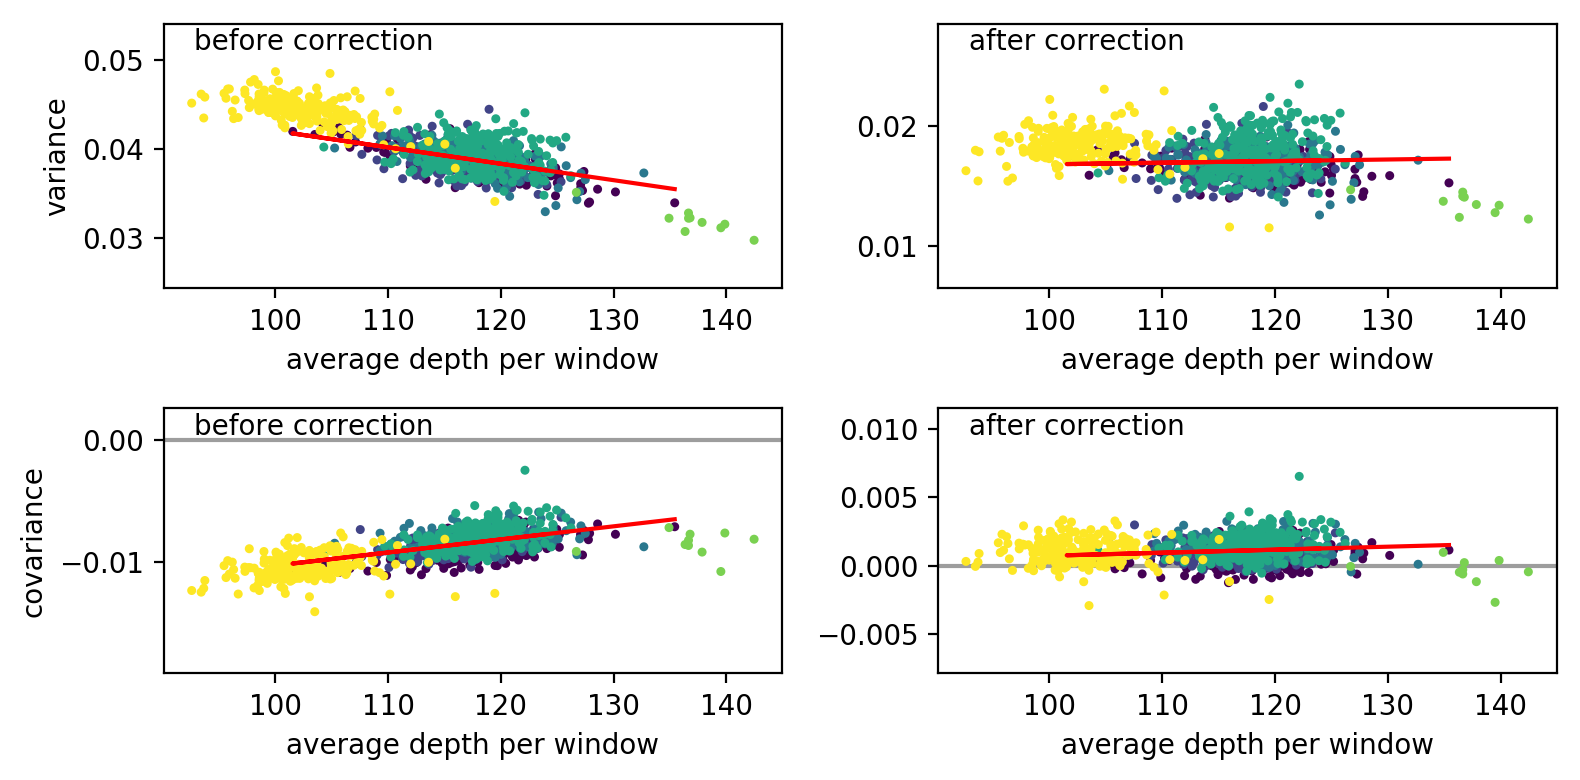

In [17]:
diagnostics = d.correction_diagnostics(exclude_seqids=['X', '4'])
_ = correction_diagnostic_plot(diagnostics)

### Bootstrapping Temporal Covs

In [34]:
temp_covs_bs = d.bootstrap_temporal_covs(B=5000, average_replicates=True, progress_bar=True)

In [35]:
with open('../data/barghi_et_al_2019/temp_covs_bootstrap.npy', 'wb') as f:
    np.save(f, temp_covs_bs)

### Bootstrapped G 

In [38]:
# G not averaging replicates
g_cis = d.bootstrap_Gs(B=5000, progress_bar=True)

# G averaging replicates
g_cis_averep = d.bootstrap_Gs(B=5000, average_replicates=True, progress_bar=True)

In [41]:
with open('../data/barghi_et_al_2019/G_bootstrap.npy', 'wb') as f:
    np.save(f, g_cis)
with open('../data/barghi_et_al_2019/G_averep_bootstrap.npy', 'wb') as f:
    np.save(f, g_cis_averep)

### Empirical Null Distributions via Sign Permutation

In [37]:
CACHED_EMPCOV_TILE = '../data/barghi_et_al_2019/empnull_tile.pkl'
CACHED_EMPCOV_TILE_WITH_CORRECTION = '../data/barghi_et_al_2019/empnull_tile_with_bias_correction.pkl'

CACHED_EMPCOV_TILE_SEQID = '../data/barghi_et_al_2019/empnull_reshape_tile_by_seqid.pkl'
CACHED_EMPCOV_GW = '../data/barghi_et_al_2019/empnull_reshape_gw.pkl'

# tile empirical null with tile-level block permutation (no bias correction)
if not os.path.exists(CACHED_EMPCOV_TILE):
    empcov_tile = d.calc_empirical_null(B=1000, by_tile=True, sign_permute_blocks='tile',
                                        bias_correction=False,
                                        progress_bar=True)
    with open(CACHED_EMPCOV_TILE, 'wb') as f:
        pickle.dump(empcov_tile, f)
else:   
    with open(CACHED_EMPCOV_TILE, 'rb') as f:
        empcov_tile = pickle.load(f)

del(empcov_tile)

# tile empirical null with tile-level block permutation (*with* bias correction)
if not os.path.exists(CACHED_EMPCOV_TILE_WITH_CORRECTION):
    empcov_tile_with_corr = d.calc_empirical_null(B=1000, by_tile=True, sign_permute_blocks='tile', 
                                                  bias_correction=True,
                                                  progress_bar=True)
    with open(CACHED_EMPCOV_TILE_WITH_CORRECTION, 'wb') as f:
        pickle.dump(empcov_tile_with_corr, f)
else:   
    with open(CACHED_EMPCOV_TILE, 'rb') as f:
        empcov_tile = pickle.load(f)
       
del(empcov_tile_with_corr)

# tile empirical null with seqid-level block permutation (no bias correction)
if not os.path.exists(CACHED_EMPCOV_TILE_SEQID):
    empcov_tile_seqid = d.calc_empirical_null(B=1000, by_tile=True, sign_permute_blocks='seqid',
                                              bias_correction=False,                                              
                                              progress_bar=True)
    with open(CACHED_EMPCOV_TILE_SEQID, 'wb') as f:
        pickle.dump(empcov_tile_seqid, f)
else:   
    with open(CACHED_EMPCOV_TILE_SEQID, 'rb') as f:
        empcov_tile_seqid = pickle.load(f)
        
del(empcov_tile_seqid)

# genome-wide empirical null (no bias correction)
if not os.path.exists(CACHED_EMPCOV_GW):
    empcov_gw = d.calc_empirical_null(B=1000, by_tile=False,
                                      bias_correction=False,                                      
                                      progress_bar=True)
    with open(CACHED_EMPCOV_GW, 'wb') as f:
        pickle.dump(empcov_gw, f)
else:
    with open(CACHED_EMPCOV_GW, 'rb') as f:
        empcov_gw = pickle.load(f)

del(empcov_gw)

/home/vinceb/projects/cvtk/cvtk/cov.py:223: RuntimeWarning: Mean of empty slice
  mean_hets = np.nanmean(hets, axis=freqs.ndim-1)
/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/vinceb/projects/cvtk/cvtk/cov.py:245: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(deltas, bias=True)
/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/vinceb/miniconda3/envs/basesci/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/vinceb/

KeyboardInterrupt: 